In [1]:
%matplotlib inline
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.utils.data as torch_data
import sklearn
from sklearn.metrics import accuracy_score

In [2]:
from poslayers.poslayers import *

In [3]:
# fetch the dataset.
digits, targets = load_digits(return_X_y=True)
digits = digits.astype(np.float32) / 255

digits_train, digits_test, targets_train, targets_test = train_test_split(digits, targets, random_state=0)

train_size = digits_train.shape[0]

input_size = 8*8
classes_n = 10

In [4]:
class MNISTData(torch_data.Dataset):
    def __init__(self, X, y):
        super(MNISTData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return (self.X[idx],self.y[idx])

In [5]:
def get_accuracy(net, val_dset):
    test_loader = torch_data.DataLoader(val_dset,batch_size = len(val_dset)) 
    net.eval()
    for X,y in test_loader:
        X = X.to(device)
        nn_outputs = net(X).detach().numpy().argmax(axis = 1)
    return accuracy_score(nn_outputs,y.detach().numpy())

In [6]:
train_dset = MNISTData(digits_train, targets_train) 
val_dset = MNISTData(digits_test, targets_test) 

## Non-convex FCN

In [56]:
class FCN(nn.Module):

    def __init__(self):
        super(FCN, self).__init__()
        self.fc0 = Dense(64, 40)
        self.fc1 = Dense(40, 20)
        self.fc2 = Dense(20, 10)

    def forward(self, input_):
        h1 = F.relu(self.fc0(input_))
        h2 = F.relu(self.fc1(h1))
        h3 = self.fc2(h2)
        return h3
    
    def get_sparsities(self):
        return {
                'Dense1': self.fc0.get_sparsity(),
                'Dense2': self.fc1.get_sparsity(),
                'Dense3': self.fc2.get_sparsity(),
        }
    
    def l1reg(self, device):
        return self.fc0.l1reg(device) + self.fc1.l1reg(device) + self.fc2.l1reg(device)

In [60]:
device = 'cpu'

net = FCN()  
criterion = F.cross_entropy
optimizer = torch.optim.Adam(net.parameters())
scheduler = None

train_loader = torch_data.DataLoader(train_dset, batch_size=30, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size=100, shuffle=False) 

In [61]:
def train_fcn(epochs, net, criterion, optimizer, train_loader,
               val_loader, ds_train, ds_val,
               scheduler=None, verbose=True, save_dir=None, l1alpha=0, model_file='model', positivate=False):
    net.to(device)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    best_val_loss = np.inf

    for epoch in range(1, epochs+1):
        net.train()
        loss = []
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            nn_outputs = net(X)

            loss1 = criterion(nn_outputs, y) + l1alpha * net.l1reg(device)
            loss1 = loss1.to(device)
            optimizer.zero_grad()
            loss1.backward()
            loss.append(loss1.item())
            optimizer.step()
            if positivate:
                net.positivate()
        net.eval()
        val_loss = []
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)
            nn_outputs = net(X)
            val_loss1 = criterion(nn_outputs,y)
            val_loss.append(val_loss1.item())
         
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)

        train_losses.append(np.mean(loss))
        val_losses.append(np.mean(val_loss))
        train_accs.append(get_accuracy(net, ds_train))
        val_accs.append(get_accuracy(net, ds_val))


        if np.mean(val_loss) < best_val_loss:
            best_val_loss = np.mean(val_loss)
            torch.save(net.state_dict(), model_file)

        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, np.mean(loss), np.mean(val_loss)))
          
    np.save(f'val_loss_{model_file}', val_losses)
    np.save(f'train_loss_{model_file}', train_losses)
    np.save(f'val_acc_{model_file}', val_accs)
    np.save(f'train_acc_{model_file}', train_accs)

In [62]:
train_fcn(300, net, criterion, optimizer, train_loader, val_loader,
          train_dset, val_dset, model_file='fcn', scheduler=scheduler)

Epoch 15/300 || Loss:  Train 0.8812 | Validation 0.9008
Epoch 30/300 || Loss:  Train 0.4753 | Validation 0.5071
Epoch 45/300 || Loss:  Train 0.3631 | Validation 0.3948
Epoch 60/300 || Loss:  Train 0.2971 | Validation 0.3356
Epoch 75/300 || Loss:  Train 0.2479 | Validation 0.3055
Epoch 90/300 || Loss:  Train 0.2122 | Validation 0.2708
Epoch 105/300 || Loss:  Train 0.1830 | Validation 0.2498
Epoch 120/300 || Loss:  Train 0.1638 | Validation 0.2447
Epoch 135/300 || Loss:  Train 0.1466 | Validation 0.2341
Epoch 150/300 || Loss:  Train 0.1334 | Validation 0.2267
Epoch 165/300 || Loss:  Train 0.1208 | Validation 0.2215
Epoch 180/300 || Loss:  Train 0.1112 | Validation 0.2316
Epoch 195/300 || Loss:  Train 0.1009 | Validation 0.2323
Epoch 210/300 || Loss:  Train 0.0927 | Validation 0.2239
Epoch 225/300 || Loss:  Train 0.0838 | Validation 0.2269
Epoch 240/300 || Loss:  Train 0.0761 | Validation 0.2282
Epoch 255/300 || Loss:  Train 0.0707 | Validation 0.2324
Epoch 270/300 || Loss:  Train 0.0660 

In [63]:
net.load_state_dict(torch.load('fcn'))

<All keys matched successfully>

In [64]:
get_accuracy(net, val_dset)

0.94

In [65]:
val_losses = np.load('val_loss_fcn.npy')
train_losses = np.load('train_loss_fcn.npy')
train_accs = np.load('train_acc_fcn.npy')
val_accs = np.load('val_acc_fcn.npy')

In [71]:
def plot_losses_accs(train_losses, val_losses, train_accs, val_accs):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
    axs[0].grid()
    axs[0].plot(train_losses, label="train loss")
    axs[0].plot(val_losses, label="val loss")
    axs[0].set_xlabel("Epoch", fontsize=14)
    axs[0].set_ylabel("Loss", fontsize=14)
    axs[0].legend(fontsize=14)
    
    axs[1].grid()
    axs[1].plot(train_accs, label="train acc")
    axs[1].plot(val_accs, label="val acc")
    axs[1].set_xlabel("Epoch", fontsize=14)
    axs[1].set_ylabel("Accuracy", fontsize=14)
    axs[1].legend(fontsize=14)
    plt.show()

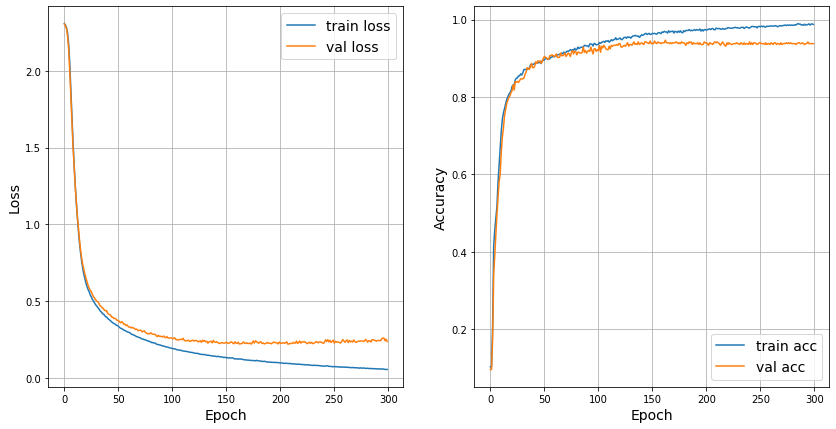

In [72]:
plot_losses_accs(train_losses, val_losses, train_accs, val_accs)

In [73]:
net.get_sparsities()

{'Dense1': 0.0, 'Dense2': 0.0, 'Dense3': 0.0}

## POSDENSE = CNN WITHOUT ADDITIONAL LAYERS

In [86]:
class ICNN(nn.Module):

    def __init__(self):
        super(ICNN, self).__init__()
        self.fcpos0 = PosDense(64, 40)
        self.fcpos1 = PosDense(40, 20)
        self.fcpos2 = PosDense(20, 10)
        self.fc = Dense(10, 10)

    def forward(self, input_):
        h1 = F.relu(self.fcpos0(input_))
        h2 = F.relu(self.fcpos1(h1))
        h3 = F.relu(self.fcpos2(h2))
        h4 = self.fc(h3)
        return h4
    
    def positivate(self):
        self.fcpos0.positivate()
        self.fcpos1.positivate()
        self.fcpos2.positivate()
    
    def get_sparsities(self):
        get_sparsity = lambda layer : (layer.weight.data == 0).sum().item() / (layer.weight.data.shape[0] * layer.weight.data.shape[1])
        return {
                'PosDense1': get_sparsity(self.fcpos0),
                'PosDense2': get_sparsity(self.fcpos1),
                'PosDense3': get_sparsity(self.fcpos2),
                'Dense' : get_sparsity(self.fc)
        }
    
    def l1reg(self, device):
        return self.fcpos0.l1reg(device) + self.fcpos1.l1reg(device) + self.fcpos2.l1reg(device) + self.fc.l1reg(device)

In [87]:
device = 'cpu'

net = ICNN()  
criterion = F.cross_entropy
optimizer = torch.optim.Adam(net.parameters())
scheduler = None

train_loader = torch_data.DataLoader(train_dset, batch_size=30, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size=100, shuffle=False) 

In [88]:
def train_icnn(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True, save_dir=None, l1alpha=0):
    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        loss = []
        for X, y in train_loader:
            nn_outputs = net(X)
            loss1 = criterion(nn_outputs, y) + l1alpha * net.l1reg()
            optimizer.zero_grad()
            loss1.backward()
            loss.append(loss1.item())
            optimizer.step()
            net.positivate()
        net.eval()
        val_loss = []
        for X, y in val_loader:
            X = X.to(device)
            nn_outputs = net(X)
            val_loss1 = criterion(nn_outputs,y)
            val_loss.append(val_loss1.item())
         
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, np.mean(loss), np.mean(val_loss)))

In [89]:
train_fcn(500, net, criterion, optimizer, train_loader, val_loader,
          train_dset, val_dset, model_file='icnn', scheduler=scheduler, positivate=True)

Epoch 25/500 || Loss:  Train 1.6013 | Validation 1.6465
Epoch 50/500 || Loss:  Train 1.4242 | Validation 1.4701
Epoch 75/500 || Loss:  Train 1.2359 | Validation 1.2800
Epoch 100/500 || Loss:  Train 0.9379 | Validation 0.9824
Epoch 125/500 || Loss:  Train 0.6697 | Validation 0.7225
Epoch 150/500 || Loss:  Train 0.5392 | Validation 0.5991
Epoch 175/500 || Loss:  Train 0.4512 | Validation 0.5165
Epoch 200/500 || Loss:  Train 0.3648 | Validation 0.4381
Epoch 225/500 || Loss:  Train 0.2928 | Validation 0.3981
Epoch 250/500 || Loss:  Train 0.2426 | Validation 0.3501
Epoch 275/500 || Loss:  Train 0.2068 | Validation 0.3067
Epoch 300/500 || Loss:  Train 0.1753 | Validation 0.2997
Epoch 325/500 || Loss:  Train 0.1528 | Validation 0.3005
Epoch 350/500 || Loss:  Train 0.1326 | Validation 0.2911
Epoch 375/500 || Loss:  Train 0.1171 | Validation 0.2720
Epoch 400/500 || Loss:  Train 0.1034 | Validation 0.2655
Epoch 425/500 || Loss:  Train 0.0869 | Validation 0.2690
Epoch 450/500 || Loss:  Train 0.07

In [93]:
net.load_state_dict(torch.load('icnn'))

<All keys matched successfully>

In [94]:
val_losses = np.load('val_loss_icnn.npy')
train_losses = np.load('train_loss_icnn.npy')
train_accs = np.load('train_acc_icnn.npy')
val_accs = np.load('val_acc_icnn.npy')

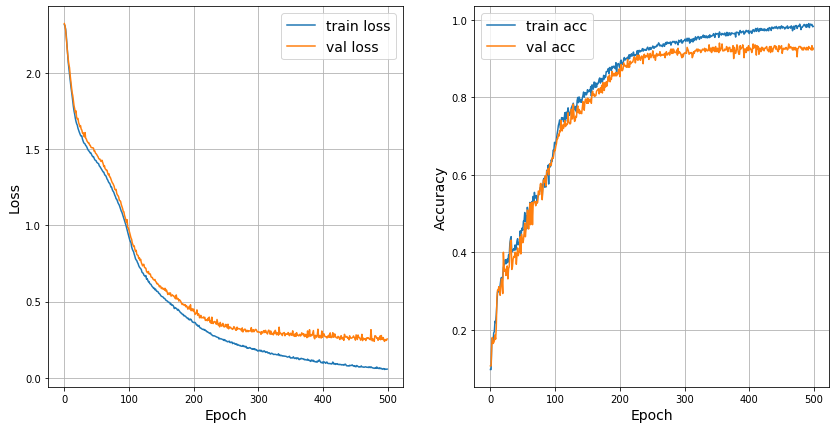

In [95]:
plot_losses_accs(train_losses, val_losses, train_accs, val_accs)

In [96]:
get_accuracy(net, val_dset)

0.9311111111111111

In [104]:
net.get_sparsities()

{'PosDense1': 0.235546875, 'PosDense2': 0.17, 'PosDense3': 0.0, 'Dense': 0.0}

## L1 + ICNN

In [180]:
device = 'cpu'

net = ICNN()  
criterion = F.cross_entropy 
optimizer = torch.optim.Adam(net.parameters())
scheduler = None

train_loader = torch_data.DataLoader(train_dset, batch_size=30, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size=100, shuffle=False) 

In [181]:
train_fcn(700, net, criterion, optimizer, train_loader, val_loader,
          train_dset, val_dset, model_file='icnnl1', scheduler=scheduler, positivate=True, l1alpha=1e-4)

Epoch 35/700 || Loss:  Train 1.6705 | Validation 1.6957
Epoch 70/700 || Loss:  Train 1.5258 | Validation 1.5524
Epoch 105/700 || Loss:  Train 1.4845 | Validation 1.5204
Epoch 140/700 || Loss:  Train 1.2429 | Validation 1.2301
Epoch 175/700 || Loss:  Train 1.0222 | Validation 1.0129
Epoch 210/700 || Loss:  Train 0.9221 | Validation 0.9354
Epoch 245/700 || Loss:  Train 0.8043 | Validation 0.8050
Epoch 280/700 || Loss:  Train 0.6481 | Validation 0.6711
Epoch 315/700 || Loss:  Train 0.5210 | Validation 0.5659
Epoch 350/700 || Loss:  Train 0.4168 | Validation 0.4690
Epoch 385/700 || Loss:  Train 0.3501 | Validation 0.3987
Epoch 420/700 || Loss:  Train 0.2966 | Validation 0.3267
Epoch 455/700 || Loss:  Train 0.2576 | Validation 0.2900
Epoch 490/700 || Loss:  Train 0.2217 | Validation 0.2484
Epoch 525/700 || Loss:  Train 0.1953 | Validation 0.2175
Epoch 560/700 || Loss:  Train 0.1705 | Validation 0.2214
Epoch 595/700 || Loss:  Train 0.1528 | Validation 0.2190
Epoch 630/700 || Loss:  Train 0.1

In [187]:
net.load_state_dict(torch.load('icnnl1'))

<All keys matched successfully>

In [188]:
val_losses = np.load('val_loss_icnnl1.npy')
train_losses = np.load('train_loss_icnnl1.npy')
train_accs = np.load('train_acc_icnnl1.npy')
val_accs = np.load('val_acc_icnnl1.npy')

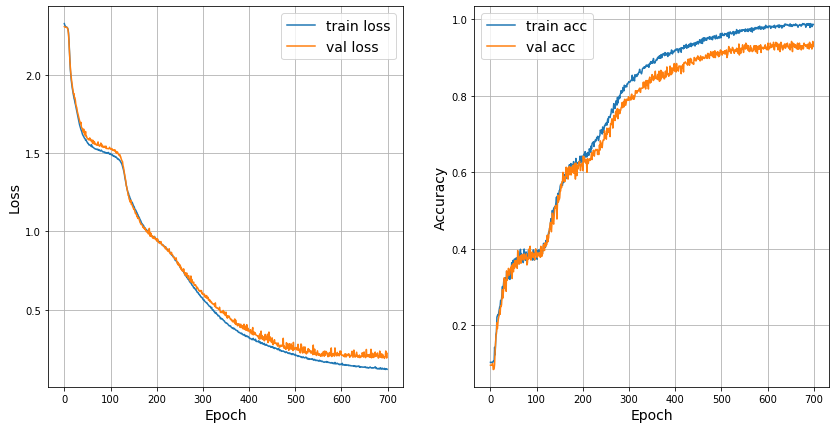

In [189]:
plot_losses_accs(train_losses, val_losses, train_accs, val_accs)

In [190]:
get_accuracy(net, val_dset)

0.9355555555555556

In [191]:
net.get_sparsities()

{'PosDense1': 0.77109375,
 'PosDense2': 0.79125,
 'PosDense3': 0.385,
 'Dense': 0.0}

# L1 + FCN

In [134]:
device = 'cpu'

net = FCN()  
criterion = F.cross_entropy
optimizer = torch.optim.Adam(net.parameters())
scheduler = None

train_loader = torch_data.DataLoader(train_dset, batch_size=30, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size=100, shuffle=False) 

In [135]:
train_fcn(400, net, criterion, optimizer, train_loader, val_loader,
          train_dset, val_dset, model_file='fcnl1', scheduler=scheduler, positivate=False, l1alpha=1e-4)

Epoch 20/400 || Loss:  Train 0.7178 | Validation 0.6711
Epoch 40/400 || Loss:  Train 0.4614 | Validation 0.3998
Epoch 60/400 || Loss:  Train 0.3546 | Validation 0.2963
Epoch 80/400 || Loss:  Train 0.2993 | Validation 0.2500
Epoch 100/400 || Loss:  Train 0.2645 | Validation 0.2299
Epoch 120/400 || Loss:  Train 0.2423 | Validation 0.2147
Epoch 140/400 || Loss:  Train 0.2236 | Validation 0.2060
Epoch 160/400 || Loss:  Train 0.2069 | Validation 0.2095
Epoch 180/400 || Loss:  Train 0.1969 | Validation 0.1927
Epoch 200/400 || Loss:  Train 0.1850 | Validation 0.1838
Epoch 220/400 || Loss:  Train 0.1773 | Validation 0.1810
Epoch 240/400 || Loss:  Train 0.1691 | Validation 0.1733
Epoch 260/400 || Loss:  Train 0.1633 | Validation 0.1786
Epoch 280/400 || Loss:  Train 0.1582 | Validation 0.1800
Epoch 300/400 || Loss:  Train 0.1521 | Validation 0.1786
Epoch 320/400 || Loss:  Train 0.1494 | Validation 0.1761
Epoch 340/400 || Loss:  Train 0.1457 | Validation 0.1785
Epoch 360/400 || Loss:  Train 0.140

In [136]:
net.load_state_dict(torch.load('fcnl1'))

<All keys matched successfully>

In [137]:
val_losses = np.load('val_loss_fcnl1.npy')
train_losses = np.load('train_loss_fcnl1.npy')
train_accs = np.load('train_acc_fcnl1.npy')
val_accs = np.load('val_acc_fcnl1.npy')

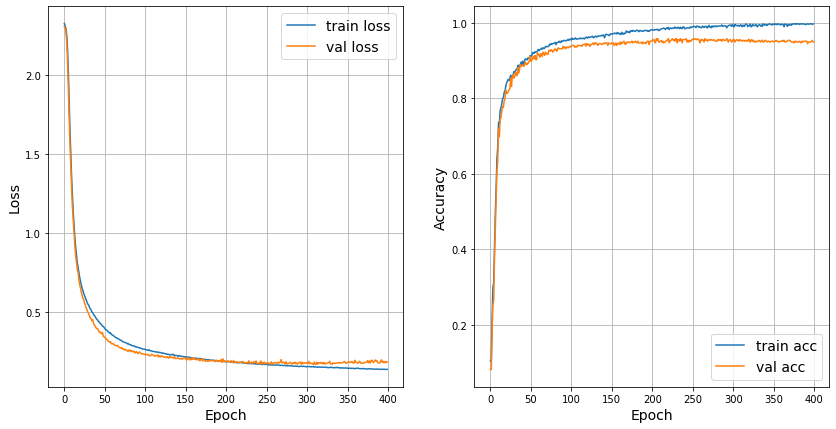

In [138]:
plot_losses_accs(train_losses, val_losses, train_accs, val_accs)

In [141]:
get_accuracy(net, val_dset)

0.9555555555555556

In [143]:
net.get_sparsities()

{'Dense1': 0.0, 'Dense2': 0.0, 'Dense3': 0.0}